This notebook contains an implementation of the One Hundred Layers Tiramisu as described in Simon Jegou et al.'s paper [The One Hundred Layers Tiramisu: Fully Convolutional DenseNets for Semantic Segmentation](https://arxiv.org/abs/1611.09326). 

In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

Using TensorFlow backend.
/home/roebius/pj/p3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# import warnings

# warnings.filterwarnings("ignore",category=DeprecationWarning)


In [3]:
limit_mem()

# Tiramisu / Camvid

Tiramisu is a fully-convolutional neural network based on DenseNet architecture. It was designed as a state-of-the-art approach to semantic image segmentation.

We're going to use the same dataset they did, CamVid.

CamVid is a dataset of images from a video. It has ~ 600 images, so it's quite small, and given that it is from a video the information content of the dataset is small. 

We're going to train this Tiramisu network from scratch to segment the CamVid dataset. This seems extremely ambitious!

## Setup

Modify the following to point to the appropriate paths on your machine

In [4]:
PATH = '/data/datasets/SegNet-Tutorial/CamVid/'

In [5]:
frames_path = PATH+'all/'

In [6]:
labels_path = PATH+'allannot/'

In [7]:
PATH = 'data/camvid/'  # - used this path as main dataset dir

The images in CamVid come with labels defining the segments of the input image. We're going to load both the images and the labels.

In [8]:
frames_path = PATH+'701_StillsRaw_full/'  # - used this path for the images

In [9]:
labels_path = PATH+'LabeledApproved_full/'  # - used this path for the label images

In [10]:
fnames = glob.glob(frames_path+'*.png')

In [11]:
lnames = [labels_path+os.path.basename(fn)[:-4]+'_L.png' for fn in fnames]
# lnames = [labels_path+os.path.basename(fn)[:-4]+'.png' for fn in fnames]

In [12]:
img_sz = (480,360)

Helper function to resize images.

In [13]:
def open_image(fn): return np.array(Image.open(fn).resize(img_sz, Image.NEAREST))

In [14]:
img = Image.open(fnames[0]).resize(img_sz, Image.NEAREST)

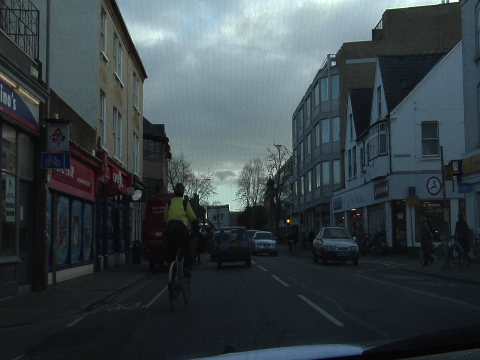

In [15]:
img

In [16]:
imgs = np.stack([open_image(fn) for fn in fnames])

In [17]:
labels = np.stack([open_image(fn) for fn in lnames])

In [18]:
imgs.shape,labels.shape

((701, 360, 480, 3), (701, 360, 480, 3))

Normalize pixel values.

In [19]:
 # - Normalizing and calculating mean and std
imgs = imgs/256
mean = np.mean(imgs)
std = np.std(imgs)
print(mean, std)

0.398404073747 0.30061602505


Save array for easier use.

In [20]:
save_array(PATH+'results/imgs.bc', imgs)
save_array(PATH+'results/labels.bc', labels)

In [21]:
imgs = load_array(PATH+'results/imgs.bc')
labels = load_array(PATH+'results/labels.bc')

Standardize

In [22]:
imgs-=0.4
imgs/=0.3

In [23]:
n,r,c,ch = imgs.shape
n,r,c,ch

(701, 360, 480, 3)

## Preprocessing

### Generator

This implementation employs data augmentation on CamVid. 

Augmentation includes random cropping / horizontal flipping, as done by `segm_generator()`. `BatchIndices()` lets us randomly sample batches from input array.

In [24]:
class BatchIndices(object):
    def __init__(self, n, bs, shuffle=False):
        self.n,self.bs,self.shuffle = n,bs,shuffle
        self.lock = threading.Lock()
        self.reset()

    def reset(self):
        self.idxs = (np.random.permutation(self.n) 
                     if self.shuffle else np.arange(0, self.n))
        self.curr = 0

    def __next__(self):
        with self.lock:
            if self.curr >= self.n: self.reset()
            ni = min(self.bs, self.n-self.curr)
            res = self.idxs[self.curr:self.curr+ni]
            self.curr += ni
            return res

In [25]:
bi = BatchIndices(10,3)
[next(bi) for o in range(5)]

[array([0, 1, 2]),
 array([3, 4, 5]),
 array([6, 7, 8]),
 array([9]),
 array([0, 1, 2])]

In [26]:
bi = BatchIndices(10,3,True)
[next(bi) for o in range(5)]

[array([5, 6, 0]),
 array([8, 4, 3]),
 array([9, 7, 1]),
 array([2]),
 array([8, 1, 3])]

In [27]:
class segm_generator(object):
    def __init__(self, x, y, bs=64, out_sz=(224,224), train=True):
        self.x, self.y, self.bs, self.train = x,y,bs,train
        self.n, self.ri, self.ci, _ = x.shape
        self.idx_gen = BatchIndices(self.n, bs, train)
        self.ro, self.co = out_sz
        self.ych = self.y.shape[-1] if len(y.shape)==4 else 1

    def get_slice(self, i,o):
        start = random.randint(0, i-o) if self.train else (i-o)
        return slice(start, start+o)

    def get_item(self, idx):
        slice_r = self.get_slice(self.ri, self.ro)
        slice_c = self.get_slice(self.ci, self.co)
        x = self.x[idx, slice_r, slice_c]
        y = self.y[idx, slice_r, slice_c]
        if self.train and (random.random()>0.5): 
            y = y[:,::-1]
            x = x[:,::-1]
        return x, y

    def __next__(self):
        idxs = next(self.idx_gen)
        items = (self.get_item(idx) for idx in idxs)
        xs,ys = zip(*items)
        return np.stack(xs), np.stack(ys).reshape(len(ys), -1, self.ych)

As an example, here's a crop of the first image.

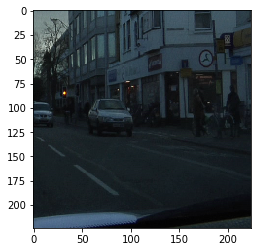

In [28]:
sg = segm_generator(imgs, labels, 4, train=False)
b_img, b_label = next(sg)
plt.imshow(b_img[0]*0.3+0.4);

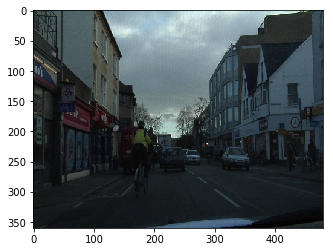

In [29]:
plt.imshow(imgs[0]*0.3+0.4);

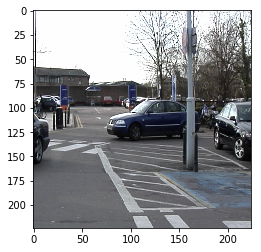

In [30]:
sg = segm_generator(imgs, labels, 4, train=True)
b_img, b_label = next(sg)
plt.imshow(b_img[0]*0.3+0.4);

### Convert labels

The following loads, parses, and converts the segment labels we need for targets.

In particular we're looking to make the segmented targets into integers for classification purposes.

In [31]:
# - Commented out original function and replaced with a modified function.
# - The modified function should be able to split also on multiple tab sequences

# def parse_code_with_re(l):
#     a,b = l.strip().split("\t")
#     return tuple(int(o) for o in a.split(' ')), b

import re
def parse_code(l):
    a,b = re.split('\\t+', l)  # - splits on one or more subsequent tabs, should they occur
    return tuple(int(o) for o in a.split(' ')), b[:-1]  # - [:-1] leaves out the newline at the end of each line

In [32]:
label_codes,label_names = zip(*[
    parse_code(l) for l in open(PATH+"label_colors.txt")])   # - use this for 12 classes like in the original notebook
#     parse_code(l) for l in open(PATH+"label_colors_32.txt")])  # - use this instead for using 32 classes

In [33]:
label_codes,label_names = list(label_codes),list(label_names)

Each segment / category is indicated by a particular color. The following maps each unique pixel to it's category.

In [34]:
# - Removing the [:5] slicing to display all the labels (each label should correspond to a class)
list(zip(label_codes,label_names))

[((128, 128, 128), 'sky'),
 ((128, 0, 0), 'building'),
 ((192, 192, 128), 'column_Pole'),
 ((128, 64, 128), 'road'),
 ((0, 0, 192), 'sidewalk'),
 ((128, 128, 0), 'tree'),
 ((192, 128, 128), 'sign'),
 ((64, 64, 128), 'fence'),
 ((64, 0, 128), 'car'),
 ((64, 64, 0), 'pedestrian'),
 ((0, 128, 192), 'bicyclist'),
 ((0, 0, 0), 'void')]

We're going to map each unique pixel color to an integer so we can classify w/ our NN. (Think how a fill-in-the color image looks)

In [35]:
code2id = {v:k for k,v in enumerate(label_codes)}
code2id  # check the id of "void" (its code is  0,0,0 from the label_color.txt file) 

{(0, 0, 0): 11,
 (0, 0, 192): 4,
 (0, 128, 192): 10,
 (64, 0, 128): 8,
 (64, 64, 0): 9,
 (64, 64, 128): 7,
 (128, 0, 0): 1,
 (128, 64, 128): 3,
 (128, 128, 0): 5,
 (128, 128, 128): 0,
 (192, 128, 128): 6,
 (192, 192, 128): 2}

In [36]:
n_classes = len(code2id) # - define a variable for the number of classes
n_classes

12

We'll include an integer for erroneous pixel values.

In [37]:
failed_code = len(label_codes)+1

In [38]:
label_codes.append((0,0,0))
label_names.append('unk')  # -note that (0,0,0) in code2id  is still 'void' 

In [39]:
def conv_one_label(i): 
    res = np.zeros((r,c), 'uint8')
    for j in range(r): 
        for k in range(c):
            try: res[j,k] = code2id[tuple(labels[i,j,k])]
            except: res[j,k] = failed_code
    return res

In [40]:
list(zip(label_codes,label_names))

[((128, 128, 128), 'sky'),
 ((128, 0, 0), 'building'),
 ((192, 192, 128), 'column_Pole'),
 ((128, 64, 128), 'road'),
 ((0, 0, 192), 'sidewalk'),
 ((128, 128, 0), 'tree'),
 ((192, 128, 128), 'sign'),
 ((64, 64, 128), 'fence'),
 ((64, 0, 128), 'car'),
 ((64, 64, 0), 'pedestrian'),
 ((0, 128, 192), 'bicyclist'),
 ((0, 0, 0), 'void'),
 ((0, 0, 0), 'unk')]

In [41]:
from concurrent.futures import ProcessPoolExecutor

In [42]:
def conv_all_labels():
    ex = ProcessPoolExecutor(8)
    return np.stack(ex.map(conv_one_label, range(n)))

Now we'll create integer-mapped labels for all our colored images.

In [43]:
%time labels_int =conv_all_labels()

CPU times: user 560 ms, sys: 404 ms, total: 964 ms
Wall time: 1min 46s


In [44]:
np.count_nonzero(labels_int==failed_code)  # - get the number of erroneus pixels 

8720249

In [45]:
# - Check how many images have a label with some pixels=failed_code
# - thanks to yashk2810 @ https://github.com/yashk2810/Semantic-Image-Segmentation/blob/master/The%20100%20Layer%20Tiramisu.ipynb 
# - get the indexes of the images that have erroneous pixels
l = []
for i in range(len(labels_int)):
    if np.count_nonzero(labels_int[i]==failed_code) > 0:
        l.append(i)
print('number of images with "bad" pixels: {}'.format(len(l)))
# print('indexes of images with "bad" pixels: {}'.format(l))
# - NOTE
# - If using the full 32 classes we will find just 1 image,
# - but when using 12 classes all the images will have pixels=failed_code

number of images with "bad" pixels: 701


Set erroneous pixels to zero.

In [46]:
# - The 0 id might be associated with some label other than 'void', so let's look for the actual 'void' id
void_id = label_codes.index((0,0,0))
void_id

11

In [47]:
labels_int[labels_int==failed_code]=void_id  # - assign the 'void' id

In [48]:
save_array(PATH+'results/labels_int.bc', labels_int)

In [49]:
labels_int = load_array(PATH+'results/labels_int.bc')

In [50]:
labels_int.shape

(701, 360, 480)

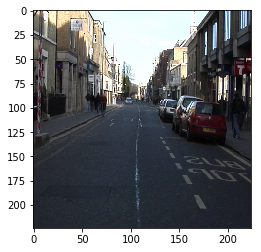

In [51]:
sg = segm_generator(imgs, labels, 4, train=True)
b_img, b_label = next(sg)
plt.imshow(b_img[0]*0.3+0.4);

Here is an example of how the segmented image looks.

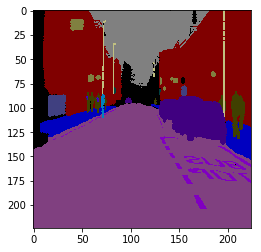

In [52]:
plt.imshow(b_label[0].reshape(224,224,3));

### Test set

Next we load test set, set training/test images and labels.

In [53]:
fn_test = set(o.strip() for o in open(PATH+'test.txt','r'))

In [54]:
is_test = np.array([o.split('/')[-1] in fn_test for o in fnames])

In [55]:
trn = imgs[is_test==False]
trn_labels = labels_int[is_test==False]
test = imgs[is_test]
test_labels = labels_int[is_test]
trn.shape,test.shape

((468, 360, 480, 3), (233, 360, 480, 3))

In [56]:
rnd_trn = len(trn_labels)
rnd_test = len(test_labels)

## The Tiramisu

Now that we've prepared our data, we're ready to introduce the Tiramisu.

Conventional CNN's for image segmentation are very similar to the kind we looked at for style transfer. Recall that it involved convolutions with downsampling (stride 2, pooling) to increase the receptive field, followed by upsampling with deconvolutions until reaching the original side. 

Tiramisu uses a similar down / up architecture, but with some key caveats.

As opposed to normal convolutional layers, Tiramisu uses the DenseNet method of concatenating inputs to outputs. Tiramisu also uses *skip connections* from the downsampling branch to the upsampling branch.

Specifically, the *skip connection* functions by concatenating the output of a Dense block in the down-sampling branch **onto** the input of the corresponding Dense block in the upsampling branch. By "corresponding", we mean the down-sample/up-sample Dense blocks that are equidistant from the input / output respectively.

One way of interpreting this architecture is that by re-introducing earlier stages of the network to later stages, we're forcing the network to "remember" the finer details of the input image.

### The pieces

This should all be familiar.

In [57]:
def relu(x): return Activation('relu')(x)
def dropout(x, p): return Dropout(p)(x) if p else x
def bn(x): return BatchNormalization()(x)  # Keras 2
def relu_bn(x): return relu(bn(x))
def concat(xs): return concatenate(xs)  # Keras 2

In [58]:
def conv(x, nf, sz, wd, p, stride=1): 
    x = Conv2D(nf, (sz, sz), kernel_initializer='he_uniform', padding='same',   # Keras 2
                      strides=(stride,stride), kernel_regularizer=l2(wd))(x)
    return dropout(x, p)

def conv_relu_bn(x, nf, sz=3, wd=0, p=0, stride=1): 
    return conv(relu_bn(x), nf, sz, wd=wd, p=p, stride=stride)

Recall the dense block from DenseNet.

In [59]:
def dense_block(n,x,growth_rate,p,wd):
    added = []
    for i in range(n):
        b = conv_relu_bn(x, growth_rate, p=p, wd=wd)
        x = concat([x, b])
        added.append(b)
    return x,added

This is the downsampling transition. 

In the original paper, downsampling consists of 1x1 convolution followed by max pooling. However we've found a stride 2 1x1 convolution to give better results.

In [60]:
def transition_dn(x, p, wd):
#     x = conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd)  # - original idea from the paper
#     return MaxPooling2D(strides=(2, 2))(x)
    return conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd, stride=2)  # - seems to work better

Next we build the entire downward path, keeping track of Dense block outputs in a list called `skip`. 

In [61]:
def down_path(x, nb_layers, growth_rate, p, wd):
    skips = []
    for i,n in enumerate(nb_layers):
        x,added = dense_block(n,x,growth_rate,p,wd)
        skips.append(x)
        x = transition_dn(x, p=p, wd=wd)
    return skips, added

This is the upsampling transition. We use a deconvolution layer.

In [62]:
def transition_up(added, wd=0):
    x = concat(added)
    _,r,c,ch = x.get_shape().as_list()
#     return Deconvolution2D(ch, 3, 3, (None,r*2,c*2,ch), init='he_uniform', 
#                border_mode='same', subsample=(2,2), W_regularizer=l2(wd))(x)
    return Conv2DTranspose(ch, (3,3), kernel_initializer='he_uniform',    # Keras 2
               padding='same', strides=(2,2), kernel_regularizer=l2(wd))(x)
#     x = UpSampling2D()(x)
#     return conv(x, ch, 2, wd, 0)

This builds our upward path, concatenating the skip connections from `skip` to the Dense block inputs as mentioned.

In [63]:
def up_path(added, skips, nb_layers, growth_rate, p, wd):
    for i,n in enumerate(nb_layers):
        x = transition_up(added, wd)
        x = concat([x,skips[i]])
        x,added = dense_block(n,x,growth_rate,p,wd)
    return x

### Build the tiramisu model

- nb_classes: number of classes
- img_input: tuple of shape (channels, rows, columns) or (rows, columns, channels)
- depth: number or layers
- nb_dense_block: number of dense blocks to add to end (generally = 3)
- growth_rate: number of filters to add per dense block
- nb_filter:  initial number of filters
- nb_layers_per_block: number of layers in each dense block.
  - If positive integer, a set number of layers per dense block.
  - If list, nb_layer is used as provided
- p: dropout rate
- wd: weight decay

In [64]:
def reverse(a): return list(reversed(a))

Finally we put together the entire network.

In [65]:
def create_tiramisu(nb_classes, img_input, nb_dense_block=6, 
    growth_rate=16, nb_filter=48, nb_layers_per_block=5, p=None, wd=0):
    
    if type(nb_layers_per_block) is list or type(nb_layers_per_block) is tuple:
        nb_layers = list(nb_layers_per_block)
    else: nb_layers = [nb_layers_per_block] * nb_dense_block

    x = conv(img_input, nb_filter, 3, wd, 0)
    skips,added = down_path(x, nb_layers, growth_rate, p, wd)
    x = up_path(added, reverse(skips[:-1]), reverse(nb_layers[:-1]), growth_rate, p, wd)
    
    x = conv(x, nb_classes, 1, wd, 0)
    _,r,c,f = x.get_shape().as_list()
    x = Reshape((-1, nb_classes))(x)
    return Activation('softmax')(x)

## Train

Now we can train. 

These architectures can take quite some time to train.

In [ ]:
limit_mem()

In [ ]:
input_shape = (224,224,3)

In [ ]:
img_input = Input(shape=input_shape)

In [ ]:
# - n_classes is the number of classes, based on the label_color.txt choice
x = create_tiramisu(n_classes, img_input, nb_layers_per_block=[4,5,7,10,12,15], p=0.2, wd=1e-4)

In [ ]:
model = Model(img_input, x)

In [ ]:
gen = segm_generator(trn, trn_labels, 3, train=True)

In [ ]:
gen_test = segm_generator(test, test_labels, 3, train=False)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=keras.optimizers.RMSprop(1e-3), metrics=["accuracy"])

In [ ]:
# - Uncomment this cell to generate an SVG picture for the model
# - thanks to aifish @ http://forums.fast.ai/t/one-hundred-layers-tiramisu/2266/19 (thx!)
# from keras.utils.visualize_util import model_to_dot
# from IPython.lib.display import FileLink
# def visualizeModel (input_model, path, filename='model.svg'):
#     model_dot = model_to_dot(input_model, show_shapes=True, show_layer_names=True)
#     model_dot.write(path+filename, prog='dot',format='svg')
#     return FileLink(path+filename)

# visualizeModel (model, PATH, 'model.svg')

In [ ]:
model.optimizer=keras.optimizers.RMSprop(1e-3, decay=1-0.99995)

In [ ]:
model.optimizer=keras.optimizers.RMSprop((1e-3))

In [ ]:
K.set_value(model.optimizer.lr, 1e-3)  # - this overrides the lr value assigned in previous 2 cells ...

In [ ]:
# - Calculate steps_per_epoch and validation_steps required by model.fit_generator
batch_size = 8
steps_per_epoch = int(np.ceil(rnd_trn/batch_size))
validation_steps = int(np.ceil(rnd_test/batch_size))
rnd_trn, steps_per_epoch, rnd_test, validation_steps

In [ ]:
model.fit_generator(gen, steps_per_epoch, epochs=1, verbose=2,  # - 100
                    validation_data=gen_test, validation_steps=validation_steps)  # Keras 2

In [ ]:
model.optimizer=keras.optimizers.RMSprop(3e-4, decay=1-0.9995)

In [ ]:
model.fit_generator(gen, steps_per_epoch, epochs=500, verbose=2, 
                    validation_data=gen_test, validation_steps=validation_steps)  # Keras 2

In [ ]:
model.optimizer=keras.optimizers.RMSprop(2e-4, decay=1-0.9995)

In [ ]:
model.fit_generator(gen, steps_per_epoch, epochs=500, verbose=2, 
                    validation_data=gen_test, validation_steps=validation_steps)  # Keras 2

In [ ]:
model.optimizer=keras.optimizers.RMSprop(1e-5, decay=1-0.9995)

In [ ]:
model.fit_generator(gen, steps_per_epoch, epochs=500, verbose=2, 
                    validation_data=gen_test, validation_steps=validation_steps)  # Keras 2

Model with larger images

In [66]:
lrg_sz = (352,480)  # - the original image size is (360, 480) but the model wouldn't fit on the GeForce Titan X GPU
gen = segm_generator(trn, trn_labels, 1, out_sz=lrg_sz, train=True)
gen_test = segm_generator(test, test_labels, 1, out_sz=lrg_sz, train=False)

In [67]:
lrg_shape = lrg_sz+(3,)
lrg_input = Input(shape=lrg_shape)

In [68]:
x = create_tiramisu(n_classes, lrg_input, nb_layers_per_block=[4,5,7,10,12,15], p=0.2, wd=1e-4)

In [69]:
lrg_model = Model(lrg_input, x)

In [70]:
lrg_model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=keras.optimizers.RMSprop(1e-4), metrics=["accuracy"])

In [71]:
# - Calculate steps_per_epoch and validation_steps required by model.fit_generator
batch_size = 1
steps_per_epoch = int(np.ceil(rnd_trn/batch_size))
validation_steps = int(np.ceil(rnd_test/batch_size))
rnd_trn, steps_per_epoch, rnd_test, validation_steps

(468, 468, 233, 233)

In [72]:
lrg_model.fit_generator(gen, steps_per_epoch, epochs=100, verbose=2,
                    validation_data=gen_test, validation_steps=validation_steps)  # Keras 2

Epoch 1/100
413s - loss: 1.8236 - acc: 0.6394 - val_loss: 3.3537 - val_acc: 0.5298
Epoch 2/100
401s - loss: 1.5289 - acc: 0.7152 - val_loss: 2.1849 - val_acc: 0.6106
Epoch 3/100
400s - loss: 1.3708 - acc: 0.7645 - val_loss: 1.7513 - val_acc: 0.6322
Epoch 4/100
400s - loss: 1.2674 - acc: 0.7906 - val_loss: 2.0034 - val_acc: 0.6582
Epoch 5/100
400s - loss: 1.1842 - acc: 0.8111 - val_loss: 2.0027 - val_acc: 0.6523
Epoch 6/100
400s - loss: 1.1122 - acc: 0.8246 - val_loss: 2.2283 - val_acc: 0.6076
Epoch 7/100
400s - loss: 1.0562 - acc: 0.8353 - val_loss: 1.8753 - val_acc: 0.6586
Epoch 8/100
400s - loss: 1.0082 - acc: 0.8428 - val_loss: 2.0318 - val_acc: 0.6550
Epoch 9/100
400s - loss: 0.9630 - acc: 0.8494 - val_loss: 1.7936 - val_acc: 0.6590
Epoch 10/100
400s - loss: 0.9229 - acc: 0.8552 - val_loss: 2.1177 - val_acc: 0.6613
Epoch 11/100
400s - loss: 0.8881 - acc: 0.8594 - val_loss: 1.8593 - val_acc: 0.6751
Epoch 12/100
400s - loss: 0.8552 - acc: 0.8639 - val_loss: 2.1435 - val_acc: 0.6514
E

400s - loss: 0.2619 - acc: 0.9434 - val_loss: 1.8863 - val_acc: 0.6766
Epoch 100/100
400s - loss: 0.2594 - acc: 0.9437 - val_loss: 1.7102 - val_acc: 0.7246


In [73]:
lrg_model.fit_generator(gen, steps_per_epoch, epochs=100, verbose=2, 
                    validation_data=gen_test, validation_steps=validation_steps)  # Keras 2

Epoch 1/100
400s - loss: 0.2579 - acc: 0.9443 - val_loss: 1.7353 - val_acc: 0.7152
Epoch 2/100
400s - loss: 0.2595 - acc: 0.9437 - val_loss: 1.9720 - val_acc: 0.6546
Epoch 3/100
400s - loss: 0.2561 - acc: 0.9442 - val_loss: 1.6057 - val_acc: 0.7374
Epoch 4/100
400s - loss: 0.2569 - acc: 0.9438 - val_loss: 1.9261 - val_acc: 0.6306
Epoch 5/100
400s - loss: 0.2568 - acc: 0.9435 - val_loss: 1.6253 - val_acc: 0.7170
Epoch 6/100
400s - loss: 0.2525 - acc: 0.9448 - val_loss: 1.5864 - val_acc: 0.7158
Epoch 7/100
400s - loss: 0.2525 - acc: 0.9443 - val_loss: 1.7243 - val_acc: 0.7037
Epoch 8/100
400s - loss: 0.2501 - acc: 0.9449 - val_loss: 2.2521 - val_acc: 0.6271
Epoch 9/100
400s - loss: 0.2509 - acc: 0.9449 - val_loss: 1.5698 - val_acc: 0.7140
Epoch 10/100
400s - loss: 0.2488 - acc: 0.9451 - val_loss: 2.1687 - val_acc: 0.6526
Epoch 11/100
400s - loss: 0.2472 - acc: 0.9454 - val_loss: 1.6444 - val_acc: 0.7061
Epoch 12/100
400s - loss: 0.2469 - acc: 0.9455 - val_loss: 2.0285 - val_acc: 0.7038
E

KeyboardInterrupt: 

In [74]:
lrg_model.optimizer=keras.optimizers.RMSprop(1e-5)

In [75]:
lrg_model.fit_generator(gen, steps_per_epoch, epochs=2, verbose=2, 
                    validation_data=gen_test, validation_steps=validation_steps)  # Keras 2

Epoch 1/2
401s - loss: 0.2115 - acc: 0.9510 - val_loss: 1.8333 - val_acc: 0.6753
Epoch 2/2
400s - loss: 0.2144 - acc: 0.9497 - val_loss: 1.8758 - val_acc: 0.6884


In [76]:
lrg_model.save_weights(PATH+'results/lrg_model_8758.h5')  # - saving the weights even if accuracy is still far from good ...

In [77]:
# - Added this to be able to load the weights directly at this point
lrg_model.load_weights(PATH+'results/lrg_model_8758.h5')

## View results

Let's take a look at some of the results we achieved.

In [78]:
colors = [(128, 128, 128), (128, 0, 0), (192, 192, 128), (128, 64, 128), (0, 0, 192),
         (128, 128, 0), (192, 128, 128), (64, 64, 128), (64, 0, 128), (64, 64, 0),
         (0, 128, 192), (0, 0, 0)]
names = ['sky', 'building', 'column_pole', 'road', 'sidewalk', 'tree', 
                'sign', 'fence', 'car', 'pedestrian', 'bicyclist', 'void']

# - the following statements get the same list directly from the dict created using the label_colors.txt file
print([(key, code2id[key]) for key in code2id.keys()])
print([label_names[code2id[key]] for key in code2id.keys()])
# print([code2id[key] for key in code2id.keys()])

[((128, 128, 128), 0), ((64, 64, 128), 7), ((128, 64, 128), 3), ((0, 0, 192), 4), ((0, 128, 192), 10), ((128, 0, 0), 1), ((64, 64, 0), 9), ((192, 192, 128), 2), ((128, 128, 0), 5), ((64, 0, 128), 8), ((0, 0, 0), 11), ((192, 128, 128), 6)]
['sky', 'fence', 'road', 'sidewalk', 'bicyclist', 'building', 'pedestrian', 'column_Pole', 'tree', 'car', 'void', 'sign']


In [79]:
gen_test = segm_generator(test, test_labels, 2, out_sz=lrg_sz, train=False)

In [80]:
preds = lrg_model.predict_generator(gen_test, rnd_test)
preds = np.argmax(preds, axis=-1)
preds = preds.reshape((-1,352,480))

In [81]:
target = test_labels.reshape((233,360,480))[:,8:]  # - cutting 8 rows to get same row number as preds

In [82]:
# (target == preds).mean()  # - doing this with non homogeneous shapes this gives an error
pred_arr = preds[:target.shape[0]]  # - defining an auxiliary array for the predictions with same shape as target
# pred_arr.shape, target.shape  # - checking the shapes
(target == pred_arr).mean()

0.68837752186565226

In [83]:
non_void = target != void_id  # - using again the previously assigned void_id variable
(target[non_void] == pred_arr[non_void]).mean()  # - using the already assigned pred_arr variable

0.71663432737912758

In [96]:
# - Defining a function for showing colors based on label id's
def color_label(label):
    colored = np.zeros((label.shape[0], label.shape[1], 3), 'uint8')
    for j in range(label.shape[0]): 
        for k in range(label.shape[1]):
            colored[j,k] = label_codes[label[j, k]]
    colored = colored[:,:,-1] 
    return colored    

In [97]:
idx=1

In [98]:
p=lrg_model.predict(np.expand_dims(test[idx,8:],0))
p = np.argmax(p[0],-1).reshape(352,480)
pred = color_label(p)

This is pretty good! We can see it is having some difficulty with the street between the light posts, but we would expect that a model that was pre-trained on a much larger dataset would perform better.

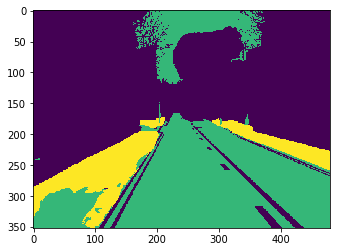

In [99]:
plt.imshow(pred)

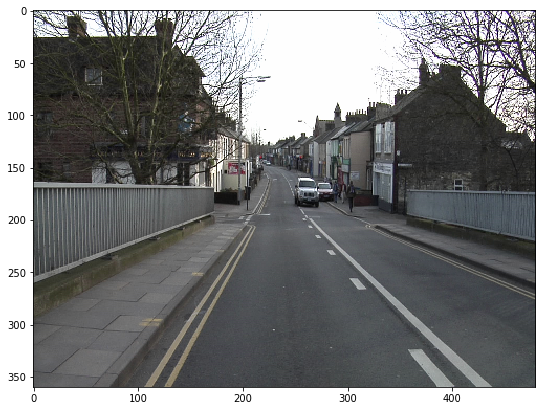

In [100]:
plt.figure(figsize=(9,9))
plt.imshow(test[idx]*0.3+0.4)

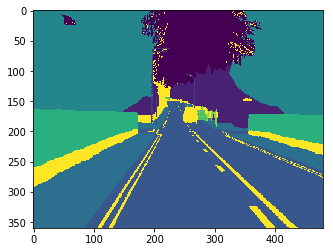

In [101]:
plt.imshow(test_labels[idx])  # - original resized label image

## End